In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import xarray as xr
import datetime

from src.utils import modif_plot

In [2]:
odir = '/scratch/project_465000269/edelleo1/Leo/SIT_observations/Bocquet_2023_SIT_climate_record/'
ofile_cr = 'CRYOSAT2/SIT_nh_c2_201011_202304.nc'
ofile_en = 'ENVISAT/SIT_nh_envisat_200210_201203.nc'
ofile_e1 = 'ERS1/SIT_nh_ers1_199410_199604.nc'
ofile_e2 = 'ERS2/SIT_nh_ers2_199510_200304.nc'

In [255]:
nc = xr.open_mfdataset(f'{odir}{ofile_cr}', combine='nested', concat_dim='time')
sit_cr = nc['sea_ice_thickness']

In [4]:
nc = xr.open_mfdataset(f'{odir}{ofile_en}', combine='nested', concat_dim='time')
sit_en = nc['sea_ice_thickness']

In [5]:
nc = xr.open_mfdataset(f'{odir}{ofile_e1}', combine='nested', concat_dim='time')
sit_e1 = nc['sea_ice_thickness']

In [228]:
nc = xr.open_mfdataset(f'{odir}{ofile_e2}', combine='nested', concat_dim='time')
sit_e2 = nc['sea_ice_thickness']

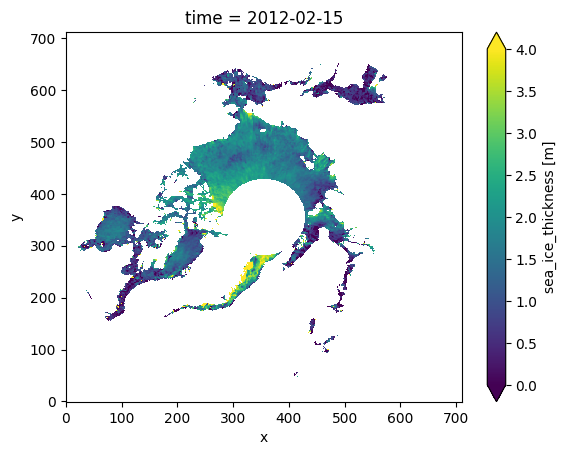

In [7]:
sit_cr.isel(time=10, y=slice(None,None,-1)).plot(vmin=0, vmax=4)

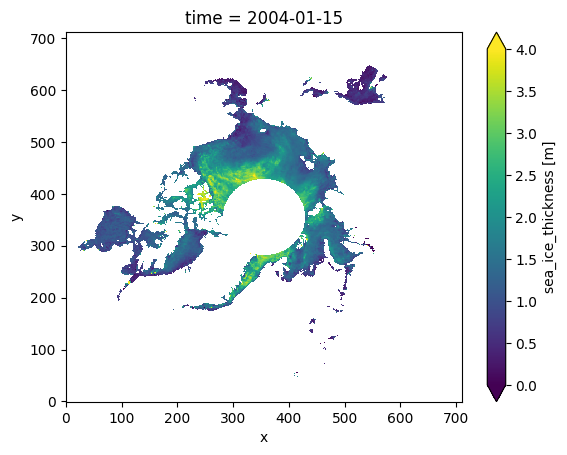

In [13]:
sit_en.isel(time=10, y=slice(None,None,-1)).plot(vmin=0, vmax=4)

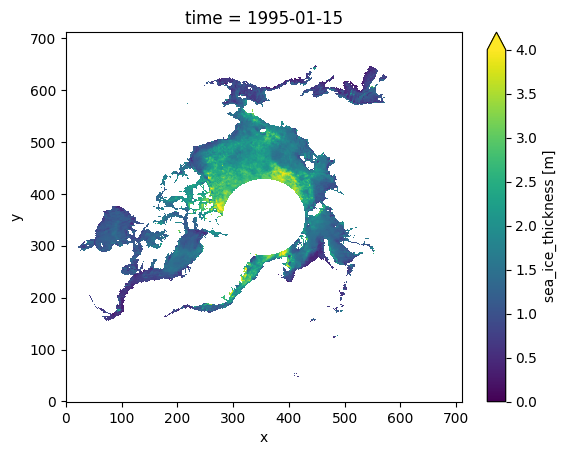

In [418]:
sit_e1.isel(time=3, y=slice(None,None,-1)).plot(vmin=0, vmax=4)

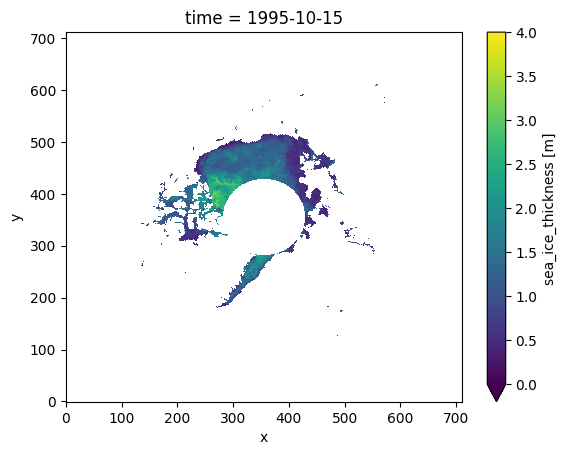

In [420]:
sit_e2.isel(time=0, y=slice(None,None,-1)).plot(vmin=0, vmax=4)

In [11]:
sitm_cr = sit_cr.mean(('x','y'))
sitm_en = sit_en.mean(('x','y'))
sitm_e1 = sit_e1.mean(('x','y'))
sitm_e2 = sit_e2.mean(('x','y'))

# TOPAZ regridded to Bocquet 2023

In [ ]:
# filename = '/scratch/project_465000269/edelleo1/Leo/outputs_v0/SITmm_SIC0_ML_gridded_Bocquet23_19920101_20221201.nc'
# nc = xr.open_mfdataset(f'{filename}', combine='nested', concat_dim='time')
# sit_ml = nc['sit_ml']

In [47]:
filename = '/scratch/project_465000269/edelleo1/Leo/outputs_v0/SITmm_SIC50_ML_gridded_Bocquet23_19920101_20221201.nc'
nc = xr.open_mfdataset(f'{filename}', combine='nested', concat_dim='time')
sit_ml = nc['sit_ml']

# _______________________________________________________

# Plot

### Time series

In [381]:
from matplotlib import dates

def draw_SITmm(sitm_e1, sitm_e2, sitm_en, sitm_cr, sitm_ml,
              savefig=False, showfig=True, rootdir='', odir=''):
    '''
    Plot monthly average Sea Ice Thickness
    For comparison between Bocquet et al. 2023 and TARDIS
    
    Parameters:
    -----------
    
            sitm_e1         :  xr DataArray, shape (time, y, x). monthly SIT for ERS1
            sitm_e2         :  xr DataArray, shape (time, y, x). monthly SIT for ERS2
            sitm_en         :  xr DataArray, shape (time, y, x). monthly SIT for Envisat
            sitm_cr         :  xr DataArray, shape (time, y, x). monthly SIT for CryoSat-2
            sitm_ml         :  xr DataArray, shape (time, y, x). monthly SIT for ML-adjusted SIT from TOPAZ4
    
    '''
    fig, ax = plt.subplots(figsize=(16, 9), constrained_layout=True)

    # Plot data
    sitm_e1.plot(lw=0, marker='v', label='ERS1', markersize=10, c='k')
    sitm_e2.plot(lw=0, marker='^', label='ERS2', markersize=10, c='k')
    sitm_en.plot(lw=0, marker='P', label='Envisat', markersize=10, c='k')
    sitm_cr.plot(lw=0, marker='*', label='CryoSat-2', markersize=10, c='k')

    sitm_ml.mean(('x','y')).plot(label='TOPAZ4-ML', color='#FB6949', lw=3, zorder=-1)

    ax.set_xlabel('')
    ax.set_ylabel('Sea Ice Thickness (m)')

    # Nice grid

    ax.xaxis.set_major_locator(dates.YearLocator(4,month=1,day=1))
    ax.xaxis.set_minor_locator(dates.YearLocator(1,month=1,day=1))

    ax.minorticks_on()
    ax.grid(True, which='major', axis='y', alpha=0.5)
    ax.grid(True, which='major', axis='x', alpha=0.5)
    ax.grid(True, which='minor', axis='x', alpha=0.2)

    # Plot Octobre and April values for SIT ML >> ugly + hard to read
    # sit_ml.where(sit_ml['time.month']==4, drop=True).mean(('x','y')).plot(lw=0, marker='_', markersize=7,  color='#FB6949')
    # sit_ml.where(sit_ml['time.month']==10, drop=True).mean(('x','y')).plot(lw=0, marker='_', markersize=7,  color='#FB6949')

    plt.legend(fontsize=16, loc='lower left')
    modif_plot.resize(fig, s=20, rx=20)

    if savefig:
        filename = f'SITmm_TP_Bocquet23_95_2022.png'
        plt.savefig(f"{rootdir}{ofig}{filename}", dpi=100)
        print(f'Figure saved as: {rootdir}{ofig}{filename}')

    if showfig:
        plt.show()

    plt.close()


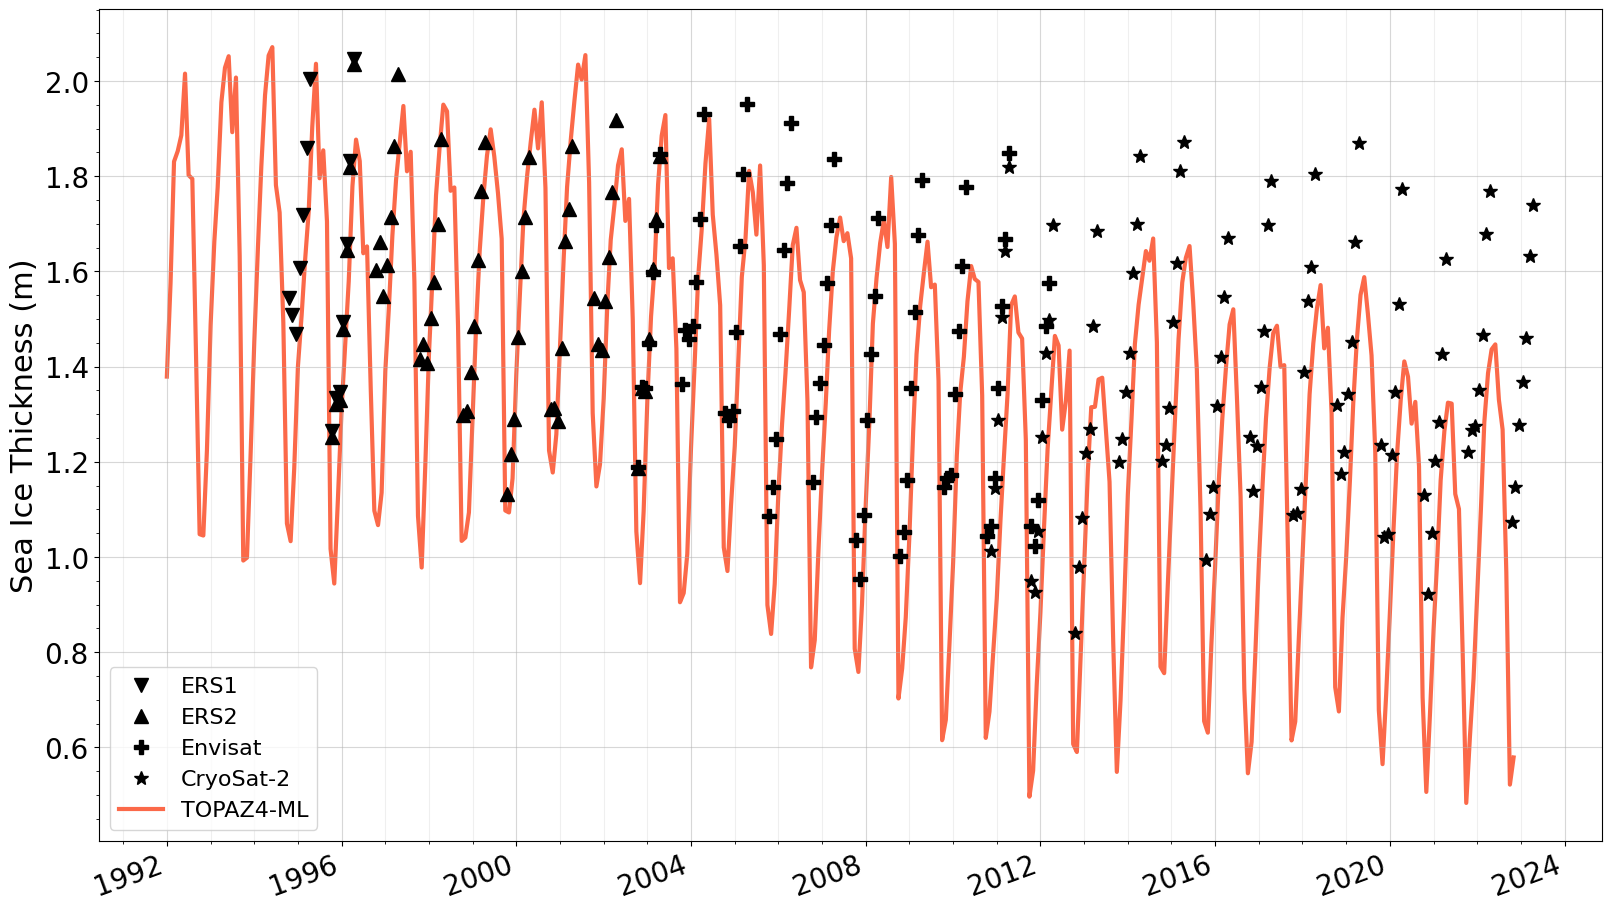

In [382]:
draw_SITmm(sitm_e1, sitm_e2, sitm_en, sitm_cr, sit_ml)

# _______________________________________________________

### Spatial Map

In [124]:
import pandas as pd

In [267]:
from mpl_toolkits.basemap import Basemap

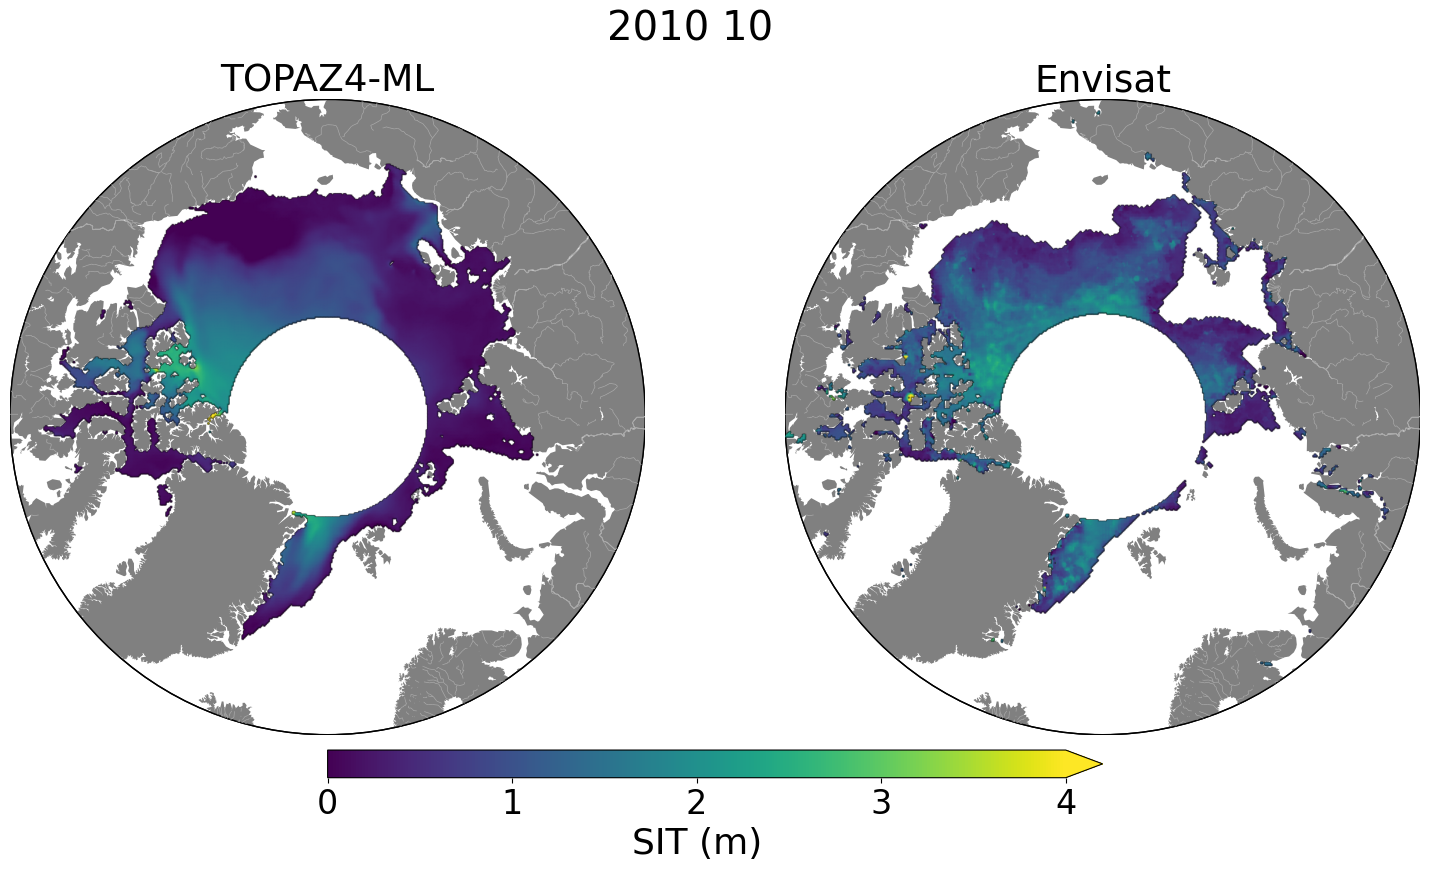

In [444]:
draw_distri_map(sit_e1, sit_e2, sit_en, sit_cr, sit_ml, month=datetime.datetime(2010,10,1))

In [442]:
def draw_distri_map(sit_e1, sit_e2, sit_en, sit_cr, sit_ml, month,
                    rootdir='', odir='', showfig=True, savefig=False):
    
    '''Draw monthly map of sea ice thickness
    
    2 subplots: sea ice thickness Observations 
                sea ice thickness ML-adjusted TOPAZ
                        
    Parameters:
    -----------
        sit_e1         :  xr DataArray, monthly SIT for ERS1. shape (time, y, x)
        sit_e2         :  xr DataArray, monthly SIT for ERS2. shape (time, y, x)
        sit_en         :  xr DataArray, monthly SIT for Envisat. shape (time, y, x)
        sit_cr         :  xr DataArray, monthly SIT for CryoSat-2. shape (time, y, x)
        sit_ml         :  xr DataArray, monthly SIT for ML-adjusted SIT from TOPAZ4. shape (time, y, x)
        month          :  datetime object, day to plot. datetime.datetime(2011,12,1)
    '''
    
    # select observations based on year:
    
    if month.year <= 1995:
        obs = sit_e1
        obs_name = 'ERS1'
    elif month.year < 2003 or (month.year==2003 and month.month <= 4):
        obs = sit_e2
        obs_name = 'ERS2'
    elif month.year < 2011:
        obs = sit_en
        obs_name = 'Envisat'
    else:
        obs = sit_cr
        obs_name = 'CryoSat-2'
        
    # identify Time index to plot for Observations
    date_obs = month.date() + datetime.timedelta(days=14)  # datetime(yyyy,mm,15)
    chrono_obs = pd.DataFrame({'date':pd.to_datetime(obs.time.to_numpy())})
    chrono_obs_dt = np.array([dt.date() for dt in chrono_obs.date])
    tidx_obs = np.where(chrono_obs_dt==date_obs)[0]
    
    if tidx_obs.size != 1:  # if month DOES NOT exists in Observation
        plt.close()
        print(f'Plot cancelled for month: {month.strftime("%Y %m")}')
        print(f'No observation found in {obs_name}.')
        return 0
    
    
    # identify index to plot for TOPAZ4-ML
    chrono = pd.DataFrame({'date':pd.to_datetime(sit_ml.time.to_numpy())})
    chrono_dt = np.array([dt.date() for dt in chrono.date])
    tidx = np.where(chrono_dt==month.date())[0]  
    
    # ----------------------------------------------------------
    ## Plot   
    fig = plt.figure(figsize=(20, 9))# , constrained_layout=True)
    gs1 = fig.add_gridspec(nrows=12, ncols=8, wspace=0.0, hspace=0.01)
    ax1 = fig.add_subplot(gs1[:11, :4])  # y, x
    ax2 = fig.add_subplot(gs1[:11, 4:]) 
    cax1 = fig.add_subplot(gs1[11:, 2:6], aspect=.15)

    # Basemap for TOPAZ4-ML
    m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='l', round=True, ax=ax1)
    m.fillcontinents(color='grey', lake_color='w')
    m.drawrivers(color='darkgrey')
    m.drawmapboundary(fill_color='w')
   
    mlons, mlats = m(sit_ml.lon.to_numpy(), sit_ml.lat.to_numpy())
    imC2 = m.pcolormesh(mlons, mlats, sit_ml.isel(time=tidx, y=slice(None,None,-1)).to_numpy()[0], vmin=0, vmax=4, shading='gouraud')

    # colorbar
    cbar = fig.colorbar(imC2, cax=cax1, label='SIT (m)', extend='max', shrink=0.5, orientation='horizontal')
    cbar.set_ticks([0,1,2,3,4])
    ax1.set_title('TOPAZ4-ML')
    
    # ----------------------------------------------------------
    # Basemap for Obserations
    m = Basemap(projection='npstere', boundinglat=65, lon_0=0, resolution='l', round=True, ax=ax2)
    m.fillcontinents(color='grey', lake_color='w')
    m.drawrivers(color='darkgrey')
    m.drawmapboundary(fill_color='w')
    mlons, mlats = m(obs.lon.to_numpy(), obs.lat.to_numpy())
    m.pcolormesh(mlons, mlats, obs.isel(time=tidx_obs).to_numpy()[0], vmin=0, vmax=4, shading='gouraud')

    ax2.set_title(obs_name)
        
    # ----------------------------------------------------------
    fig.suptitle(f'{month.strftime("%Y %m")}')
    modif_plot.resize(fig, s=24)

    if savefig:
        sdate = f'{month.strftime("%Y%m")}'
        ofile = f'{rootdir}{odir}SITmm_TOPAZ4ML_{obs_name}_{sdate}.png'
        plt.savefig(f"{ofile}", dpi=150, bbox_inches='tight')
        print(f'Saved as : {ofile}')
    
    if showfig:
        plt.show()
    
    plt.close()


# Plot and save all months

In [409]:
rootdir = '/scratch/project_465000269/edelleo1/'
fig_dir = 'Leo/results/Bocquet23/'

In [388]:
from dateutil.relativedelta import relativedelta

In [393]:
d1 = datetime.datetime(1994,1,1)
# d2 = datetime.datetime(2023,12,1)

all_months = np.array([d1 + relativedelta(months=x) for x in range(12*(2024-1994))])

Plot cancelled for month: 1994 01
No observation found in ERS1.
Plot cancelled for month: 1994 02
No observation found in ERS1.
Plot cancelled for month: 1994 03
No observation found in ERS1.
Plot cancelled for month: 1994 04
No observation found in ERS1.
Plot cancelled for month: 1994 05
No observation found in ERS1.
Plot cancelled for month: 1994 06
No observation found in ERS1.
Plot cancelled for month: 1994 07
No observation found in ERS1.
Plot cancelled for month: 1994 08
No observation found in ERS1.
Plot cancelled for month: 1994 09
No observation found in ERS1.
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_199410.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_199411.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_199412.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_199501.png
Saved as : /scratch/project_

Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_200204.png
Plot cancelled for month: 2002 05
No observation found in ERS2.
Plot cancelled for month: 2002 06
No observation found in ERS2.
Plot cancelled for month: 2002 07
No observation found in ERS2.
Plot cancelled for month: 2002 08
No observation found in ERS2.
Plot cancelled for month: 2002 09
No observation found in ERS2.
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_200210.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_200211.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_200212.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_200301.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_200302.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OB

Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201004.png
Plot cancelled for month: 2010 05
No observation found in Envisat.
Plot cancelled for month: 2010 06
No observation found in Envisat.
Plot cancelled for month: 2010 07
No observation found in Envisat.
Plot cancelled for month: 2010 08
No observation found in Envisat.
Plot cancelled for month: 2010 09
No observation found in Envisat.
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201010.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201011.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201012.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201101.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201102.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SI

Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201803.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201804.png
Plot cancelled for month: 2018 05
No observation found in CryoSat-2.
Plot cancelled for month: 2018 06
No observation found in CryoSat-2.
Plot cancelled for month: 2018 07
No observation found in CryoSat-2.
Plot cancelled for month: 2018 08
No observation found in CryoSat-2.
Plot cancelled for month: 2018 09
No observation found in CryoSat-2.
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201810.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201811.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201812.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bocquet23/SITmm_TOPAZ4ML_OBS_201901.png
Saved as : /scratch/project_465000269/edelleo1/Leo/results/Bo

IndexError: index 0 is out of bounds for axis 0 with size 0

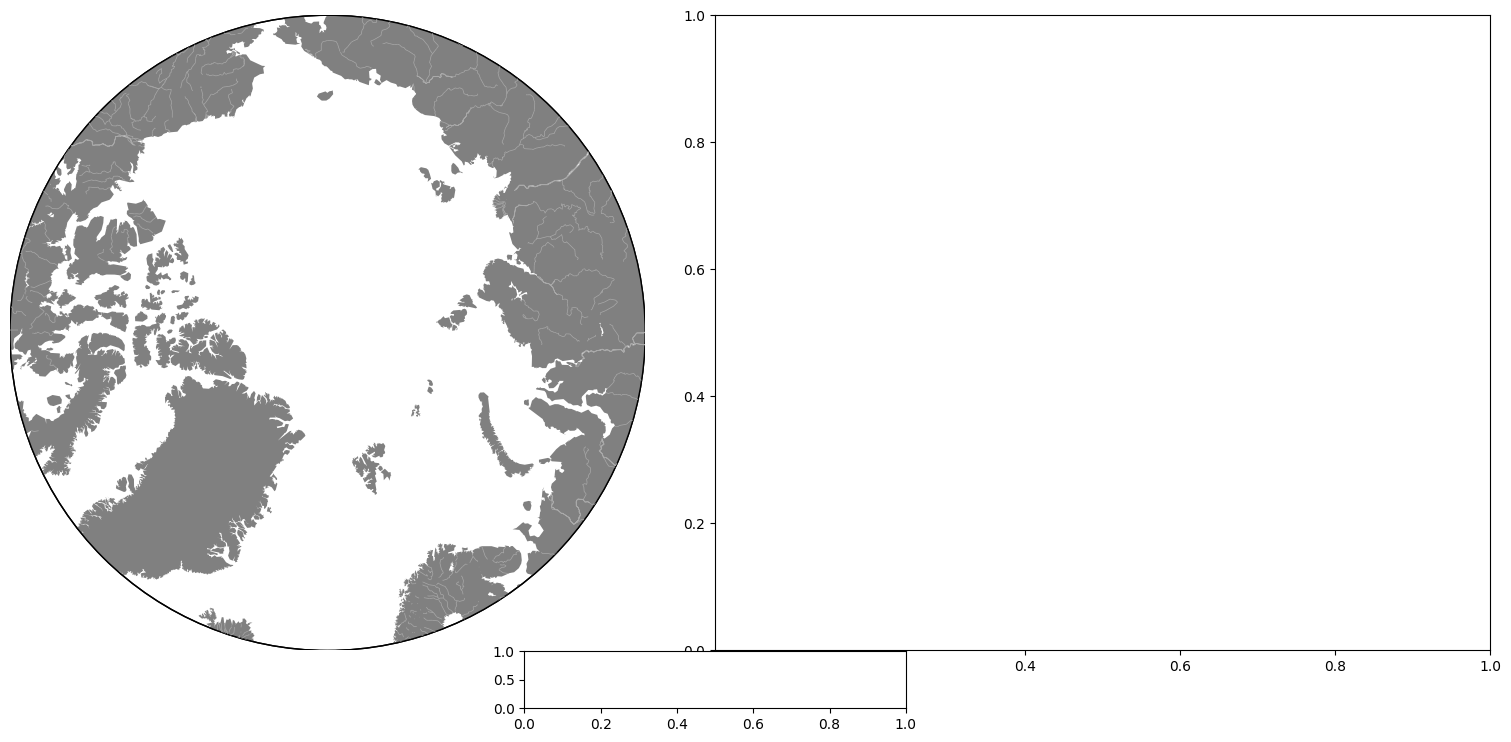

In [445]:
for mon in all_months[:]:
    draw_distri_map(sit_e1, sit_e2, sit_en, sit_cr, sit_ml, month=mon, 
                    rootdir=rootdir, odir=fig_dir, showfig=False, savefig=True)